# Create frequent public transport stops analysis


This notebook describes a process to retain public transit stops points with frequent services

### Method: Stop headway analysis using average frequencies of departure during day time

- group by service date, then count the frequencies of departure for each stop
- calculate the average headway during daytime over departure for normal weekdays
- approach taken by Carl Higgs (20200106) following [tidytransit](http://tidytransit.r-transit.org/articles/servicepatterns.html)



### Notes:

- Input data format, including which tables, which columns, which order and handling of nulls - you'll need to customise this for each city.  A handy guide to the format of GTFS fields is [here](https://developers.google.com/transit/gtfs/reference/#tripstxt).

- GTFS feeds sourced in same season (?) and school term
    - we have vastly different climates across our cities --- so should perhaps aim for Spring? if we chose arbitrary feeds, some in winter and some in summer, our different cities could have vastly different conditions (particularly the snowy ones)
- Week days (Monday to Friday)
    - Day time (7am to 7pm; as travel during day is important for different segments of community)
 
- We may need to consider details of how headway is operationalised (ie. spot checks do the results look reasonable, and if not how do we deal with it?  this is why I took the maximum headway of the two directions as it at the time seemed a simple and reasonable approach to recognise that a stop need only be frequently serviced in one direction - which is not literally interpreted as 'direction on the road', its do with the route itself.  There may be other methods to consider.)

Previous working branch using SQL:

https://github.com/shiqin-liu/global-indicators/blob/phoenix/process/07_create_frequent_public_transport.ipynb  


In [1]:
#For UrbanAccess installation instructions see: https://udst.github.io/urbanaccess/installation.html
#conda install -c udst urbanaccess


In [34]:
import pandas as pd
import geopandas as gpd
import os
import time   
import networkx as nx
import osmnx as ox
import numpy as np
import matplotlib.pyplot as plt

import calendar
import datetime

import urbanaccess as ua

# module with functions to load GTFS data into dataframes
# revise based on origional load function from UrbanAccess, take out the add agency and route type features
import ua_load 

# module with functions to calculate the average headway during the timeframe over departure
import gtfs_headway_analysis as gha

from shapely.geometry import shape,Point, LineString, Polygon

%matplotlib inline


In [30]:
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)


In [31]:
# get lat lon bounding box for each study region
# for plotting
for layer in ['Buffered Adelaide', 'Buffered Melbourne', 'Buffered Sydney']:
    crs = 'epsg:7845'
    # load shapefile
    shape = gpd.GeoDataFrame.from_file('data/Transport/Australian stops for reference/gtfs_2020_02_14_headway_au_global_indicators.gpkg', 
                  layer=layer)
    # create buffer
    polygon = shape['geometry'].iloc[0]
    polygon_proj = ox.project_geometry(polygon, crs=crs, to_crs=None, to_latlong=True)
    # get bounding box
    bbox = polygon_proj[0].bounds
    print(layer, ' : ', bbox)
    
#minx , miny , maxx , maxy

Buffered Adelaide  :  (138.46098212857206, -35.15966609024628, 138.74830806651352, -34.71454282915053)
Buffered Melbourne  :  (144.59067957842007, -38.21131973169178, 145.39847326519424, -37.61837232908795)
Buffered Sydney  :  (150.6290606117829, -34.12321411958463, 151.3206735172292, -33.66275213092711)


In [32]:
# set up study region GTFS config
GTFS = {'adelaide':{'gtfs_filename':'data/Transport/2019/gtfs_au_sa_adelaidemetro_20191004',
                    'gtfs_provider' : 'Adelaide Metro',
                    'gtfs_year' : '2019',
                    # define month and day for "representative period" ie. not in school time
                    'start_date_mmdd' : '20191008', 
                    'end_date_mmdd' : '20191205',
                    # get bounding box from study region boundary shapefile
                    # bounding box formatted as a 4 element tuple: (lng_max, lat_min, lng_min, lat_max)
                    # you can generate a bounding box by going to http://boundingbox.klokantech.com/ and selecting the CSV format.
                    'bbox' : (138.46098212857206, -35.15966609024628, 138.74830806651352, -34.71454282915053), 
                    # define modes for GTFS feed(s) as per agency_id codes in agency.txt below
                    'modes' : {
                        'bus' : {'route_types': [3],
                                  'peak_time' : ['07:00:00', '09:00:00'], 
                                  'day_time' : ['07:00:00', '19:00:00'],
                                  'intervals': 30,
                                 'agency_id': None},
                        'tram':{'route_types': [0], 
                                'peak_time' : ['07:00:00', '09:00:00'],
                                'day_time' : ['07:00:00', '19:00:00'],
                                'intervals': 30,
                                'agency_id': None},
                        'train':{'route_types': [1,2], 
                                'peak_time' : ['07:00:00', '09:00:00'],
                                'day_time' : ['07:00:00', '19:00:00'],
                                'intervals': 30,
                                'agency_id': None},
                        'ferry':{'route_types': [4], 
                                'peak_time' : ['07:00:00', '09:00:00'],
                                'day_time' : ['07:00:00', '19:00:00'],
                                'intervals': 30,
                                'agency_id': None}
                    }
                   },
        'melbourne':{'gtfs_filename':'data/Transport/2019/gtfs_au_vic_ptv_20191004',
                    'gtfs_provider' : 'Public Transport Victoria',
                    'gtfs_year' : '2019',
                    # define month and day for "representative period" ie. not in school time
                    'start_date_mmdd' : '20191008', 
                    'end_date_mmdd' : '20191205',
                     'bbox' : (144.59067957842007, -38.21131973169178, 145.39847326519424, -37.61837232908795),
                    # define modes for GTFS feed(s) as per agency_id codes in agency.txt below
                    'modes' : {
                        'bus' : {'route_types': [3],
                                  'peak_time' : ['07:00:00', '09:00:00'], 
                                  'day_time' : ['07:00:00', '19:00:00'],
                                  'intervals': 30,
                                 'agency_id': [4, 6]},
                        'tram':{'route_types': [0], 
                                'peak_time' : ['07:00:00', '09:00:00'],
                                'day_time' : ['07:00:00', '19:00:00'],
                                'intervals': 30,
                                'agency_id': [3]},
                        'train':{'route_types': [1,2], 
                                'peak_time' : ['07:00:00', '09:00:00'],
                                'day_time' : ['07:00:00', '19:00:00'],
                                'intervals': 30,
                                'agency_id': [1,2]}

                    }
                   },
        'sydney' : {'gtfs_filename':'data/Transport/2019/gtfs_au_nsw_tfnsw_complete_20190619',
                    'gtfs_provider' : 'Transport for NSW',
                    'gtfs_year' : '2019',
                    # define month and day for "representative period" ie. not in school time
                    'start_date_mmdd' : '20191008', 
                    'end_date_mmdd' : '20191205',
                    'bbox' : (150.6290606117829, -34.12321411958463, 151.3206735172292, -33.66275213092711),
                    # define modes for GTFS feed(s) as per agency_id codes in agency.txt below
                    'modes' : {
                        'bus' : {'route_types': [700,712,714],
                                  'peak_time' : ['07:00:00', '09:00:00'], 
                                  'day_time' : ['07:00:00', '19:00:00'],
                                  'intervals': 30,
                                 'agency_id': None},
                        'tram':{'route_types': [0], 
                                'peak_time' : ['07:00:00', '09:00:00'],
                                'day_time' : ['07:00:00', '19:00:00'],
                                'intervals': 30,
                                'agency_id': None},
                        'train':{'route_types': [2,401], 
                                'peak_time' : ['07:00:00', '09:00:00'],
                                'day_time' : ['07:00:00', '19:00:00'],
                                'intervals': 30,
                                'agency_id': None},

                        'ferry':{'route_types': [4], 
                                'peak_time' : ['07:00:00', '09:00:00'],
                                'day_time' : ['07:00:00', '19:00:00'],
                                'intervals': 30,
                                'agency_id': None}
                    }
                   }
       }
                    



In [33]:
# set up a study region config to run in this notebook
city = 'adelaide'

gtfsfeed_path = GTFS['{}'.format(city)]['gtfs_filename']
start_date=GTFS['{}'.format(city)]['start_date_mmdd']
end_date=GTFS['{}'.format(city)]['end_date_mmdd']

peak_hour = GTFS['{}'.format(city)]['modes']['bus']['day_time']
start_hour = peak_hour[0]
end_hour = peak_hour[1]

headway_intervals = GTFS['{}'.format(city)]['modes']['bus']['intervals']
route_types = GTFS['{}'.format(city)]['modes']['bus']['route_types']
agency_ids = GTFS['{}'.format(city)]['modes']['bus']['agency_id']

shape_layer_name = 'Buffered Adelaide'


# Load GTFS data into an UrbanAccess transit data frame

### Using UrbanAccess as source for:
- The settings object
- The feeds object and searching for GTFS feeds
- Downloading GTFS data
- Loading GTFS data into a UrbanAccess transit data object
- conduct heaway analysis using maxi interdeparture time method


In [13]:
# revise based on origional function from UrbanAccess, take out the add agency and route type features
loaded_feeds = ua_load.gtfsfeed_to_df(gtfsfeed_path=gtfsfeed_path)

--------------------------------
GTFS text file header whitespace check completed. Took 5.09 seconds
--------------------------------
Processing GTFS feed: gtfs_au_sa_adelaidemetro_20191004
Successfully converted ['departure_time'] to seconds past midnight and appended new columns to stop_times. Took 3.63 seconds
1 GTFS feed file(s) successfully read as dataframes:
     gtfs_au_sa_adelaidemetro_20191004
     Took 15.70 seconds


### The transit data object

The output is a global `urbanaccess_gtfs_df` object that can be accessed with the specified variable `loaded_feeds`. This object holds all the individual GTFS feed files aggregated together with each GTFS feed file type in separate Pandas DataFrames to represent all the loaded transit feeds in a metropolitan area. 

Quickly view the transit stop locations

In [10]:
#loaded_feeds.stops.plot(kind='scatter', x='stop_lon', y='stop_lat', s=0.1)


# Calculate stop level headways


In [11]:
"""hold this condition 
#select daytime bus service
loaded_feeds.stop_times = loaded_feeds.stop_times.sort_values(['trip_id', 'stop_sequence'])
loaded_feeds.stop_times = loaded_feeds.stop_times[(loaded_feeds.stop_times['departure_time'] >= '07:00:00') 
                                                  & (loaded_feeds.stop_times['departure_time'] <= '19:00:00')]

# select stops with ealiest service before 7:30am, and lastest stop before 18:30pm. groupby stop id
stop_first_peak_service_bus = (loaded_feeds.stop_times.groupby(loaded_feeds.stop_times.stop_id).departure_time.min() <= '07:30:00')
stop_last_peak_service_bus = (loaded_feeds.stop_times.groupby(loaded_feeds.stop_times.stop_id).departure_time.max() >= '18:30:00')


loaded_feeds.stop_times = loaded_feeds.stop_times.set_index('stop_id') #set stop_id as index columns
loaded_feeds.stop_times = loaded_feeds.stop_times[(stop_first_peak_service_bus) & (stop_last_peak_service_bus)].reset_index()
"""

"hold this condition \n#select daytime bus service\nloaded_feeds.stop_times = loaded_feeds.stop_times.sort_values(['trip_id', 'stop_sequence'])\nloaded_feeds.stop_times = loaded_feeds.stop_times[(loaded_feeds.stop_times['departure_time'] >= '07:00:00') \n                                                  & (loaded_feeds.stop_times['departure_time'] <= '19:00:00')]\n\n# select stops with ealiest service before 7:30am, and lastest stop before 18:30pm. groupby stop id\nstop_first_peak_service_bus = (loaded_feeds.stop_times.groupby(loaded_feeds.stop_times.stop_id).departure_time.min() <= '07:30:00')\nstop_last_peak_service_bus = (loaded_feeds.stop_times.groupby(loaded_feeds.stop_times.stop_id).departure_time.max() >= '18:30:00')\n\n\nloaded_feeds.stop_times = loaded_feeds.stop_times.set_index('stop_id') #set stop_id as index columns\nloaded_feeds.stop_times = loaded_feeds.stop_times[(stop_first_peak_service_bus) & (stop_last_peak_service_bus)].reset_index()\n"

# Stop headway analysis using average departure time during normal weekday daytime

- Identify feeds start and end dates that that a stop is a 30-minute frequency stop  
- group by service date, then count the frequencies of departure for each stop
- calculate the average headway during the timeframe over departure
- approach taken by Carl Higgs (20200106) following [tidytransit](http://tidytransit.r-transit.org/articles/servicepatterns.html)

In [18]:
stops_headway = gha.get_hlc_stop_frequency(loaded_feeds, start_hour, end_hour, start_date, 
                           end_date, route_types, agency_ids, 
                           dow=['monday','tuesday','wednesday','thursday','friday'])

/home/jovyan/work/process/gtfs_headway_analysis.py:214: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  & (date_service_df['date'] <= end_date_mmdd)].drop_duplicates()


In [19]:
# select average departure headway less than or equal to maxi headway frequency intervals
stop_30_mins_headway = stops_headway[stops_headway['headway'] <= 20]

# get spatial features for freqent stops
stop_30_mins_final = pd.merge(stop_30_mins_headway, loaded_feeds.stops, how='left', on='stop_id')

# add stop id geometry
stop_30_mins_final['geometry'] = stop_30_mins_final.apply(
    lambda row: Point(row['stop_lon'], row['stop_lat']), axis=1)
stop_30_mins_final = gpd.GeoDataFrame(stop_30_mins_final)

In [20]:
len(stop_30_mins_final)

2653

In [21]:
len(loaded_feeds.stops.drop_duplicates(subset='stop_id'))

7746

# Plot bus stop and freqent bus stop

In [25]:
# get the study region boundary gdf
shape = gpd.GeoDataFrame.from_file('data/Transport/Australian stops for reference/gtfs_2020_02_14_headway_au_global_indicators.gpkg', 
                  layer=shape_layer_name)

polygon = shape['geometry'].iloc[0]
crs = shape.crs

polygon_proj = ox.project_geometry(polygon, crs=crs, to_crs=None, to_latlong=True)
shape_proj = gpd.GeoDataFrame(polygon_proj[0]).rename(columns={0:'geometry'})
shape_proj = gpd.GeoDataFrame(shape_proj,  geometry='geometry')

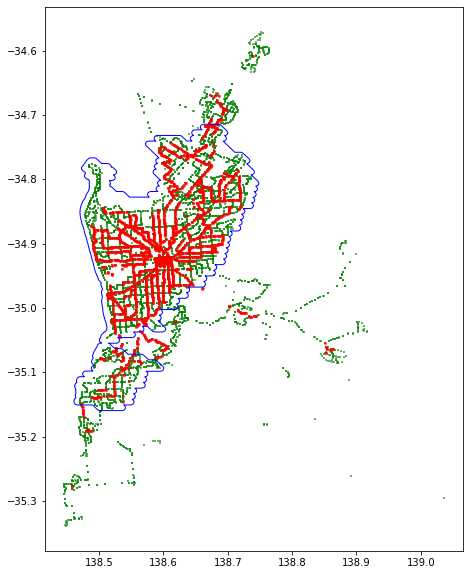

In [26]:
# set spatial geometry for all stops 
loaded_feeds.stops['geometry'] = loaded_feeds.stops.apply(
    lambda row: Point(row['stop_lon'], row['stop_lat']), axis=1)
all_stops_gdf = gpd.GeoDataFrame(loaded_feeds.stops)

# plot the stops
fig, ax = plt.subplots(figsize=(10, 10))
ax = all_stops_gdf.plot(ax=ax, color='green', marker='+', markersize=5, alpha=0.6)
ax = stop_30_mins_final.plot(ax=ax, color='red', marker='o', markersize=5, alpha=0.5)
ax = shape_proj.plot(ax=ax, color='none', edgecolor='blue')

#ax.set_axis_off()

plt.show()

In [27]:
# select stops within study region boundary
len(stop_30_mins_final[(stop_30_mins_final.within(polygon_proj[0]))])

2484

In [28]:
# all stops within study region boundary
len(all_stops_gdf[(all_stops_gdf.within(polygon_proj[0]))])

6198

# Run all cities GTFS frequent stop analysis
TODO: move to a python script (done)

In [7]:
# get the work directory
dirname = os.path.abspath('') 

# geopackage path where to save processing layers
gpkgPath_output = os.path.join(dirname, 'data/Transport', 'frequent_transit_headway_2020April_python.gpkg')


for city in GTFS.keys():
    #print(city)
    city_config = GTFS['{}'.format(city)]
    gtfsfeed_path = city_config['gtfs_filename']
    start_date = city_config['start_date_mmdd']
    end_date = city_config['end_date_mmdd']
    authority = city_config['gtfs_provider']
    hour = 'day_time'
    
    # load GTFS Feed
    loaded_feeds = ua_load.gtfsfeed_to_df(gtfsfeed_path=gtfsfeed_path)
    
    stop_frequent = pd.DataFrame()
    for mode in city_config['modes'].keys():
        print(mode)
        startTime = time.time()
        print('Start to process {} {} analysis during {}'.format(city, mode, hour))

        hour_1 = city_config['modes']['{}'.format(mode)]['{}'.format(hour)]
        start_hour = hour_1[0]
        end_hour = hour_1[1]

        headway_intervals = city_config['modes']['{}'.format(mode)]['intervals']
        route_types = city_config['modes']['{}'.format(mode)]['route_types']
        agency_ids = city_config['modes']['{}'.format(mode)]['agency_id']

        stops_headway = gha.get_hlc_stop_frequency(loaded_feeds, start_hour, end_hour, start_date, 
                           end_date, route_types, agency_ids, 
                           dow=['monday','tuesday','wednesday','thursday','friday'])

        # select average departure headway less than or equal to maxi headway frequency intervals
        #stop_frequent_headway = stops_headway[stops_headway['headway'] <= headway_intervals]

        if len(stops_headway) > 0:
            stop_frequent_final = pd.merge(stops_headway, loaded_feeds.stops, how='left', on='stop_id')
            stop_frequent_final['authority'] = authority
            stop_frequent_final['mode'] = mode
            stop_frequent = stop_frequent.append(stop_frequent_final)
            print('     Complete {} ({}) {} during {} with {} stop counts in {} seconds'.format(
                city, authority, mode, hour, len(stops_headway), time.time() - startTime))
        else:
            continue

    # get spatial features for freqent stops
    # add stop id geometry
    stop_frequent['geometry'] = stop_frequent.apply(
        lambda row: Point(row['stop_lon'], row['stop_lat']), axis=1)
    stop_frequent_gdf = gpd.GeoDataFrame(stop_frequent)


    # save to output file
    # save the frequent stop by study region and modes to a new layer in geopackage
    stop_frequent_gdf.to_file(
        gpkgPath_output,
        layer='{}_{}min_stops_{}_{}_{}'.format(
            city, headway_intervals, hour, start_date, end_date),
        driver='GPKG')



--------------------------------
GTFS text file header whitespace check completed. Took 4.42 seconds
--------------------------------
Processing GTFS feed: gtfs_au_sa_adelaidemetro_20191004
Successfully converted ['departure_time'] to seconds past midnight and appended new columns to stop_times. Took 3.78 seconds
1 GTFS feed file(s) successfully read as dataframes:
     gtfs_au_sa_adelaidemetro_20191004
     Took 10.09 seconds
bus
Start to process adelaide bus analysis during day_time


/home/jovyan/work/process/gtfs_headway_analysis.py:214: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  & (date_service_df['date'] <= end_date_mmdd)].drop_duplicates()


     Complete adelaide (Adelaide Metro) bus during day_time with 7352 stop counts in 7.972742319107056 seconds
tram
Start to process adelaide tram analysis during day_time
     Complete adelaide (Adelaide Metro) tram during day_time with 62 stop counts in 0.2620275020599365 seconds
train
Start to process adelaide train analysis during day_time
     Complete adelaide (Adelaide Metro) train during day_time with 173 stop counts in 0.3063797950744629 seconds
ferry
Start to process adelaide ferry analysis during day_time
--------------------------------
GTFS text file header whitespace check completed. Took 42.55 seconds
--------------------------------
Processing GTFS feed: gtfs_au_vic_ptv_20191004
Successfully converted ['departure_time'] to seconds past midnight and appended new columns to stop_times. Took 25.33 seconds
1 GTFS feed file(s) successfully read as dataframes:
     gtfs_au_vic_ptv_20191004
     Took 80.22 seconds
bus
Start to process melbourne bus analysis during day_time
   